# Setup StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery

https://github.com/orpatashnik/StyleCLIP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

os.chdir('/content/gdrive/MyDrive')
!git clone https://github.com/omertov/encoder4editing.git /content/gdrive/MyDrive/encoder4editing/
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

% cd
% cd /content/gdrive/MyDrive

! pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git -t /content/gdrive/MyDrive/CLIP 
! git clone https://github.com/orpatashnik/StyleCLIP /content/gdrive/MyDrive/StyleCLIP

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.5 MB/s eta 0:03:42tcmalloc: large alloc 1147494400 bytes == 0x56391cfbc000 @  0x7efc3bc54615 0x5638e468417c 0x5638e476447a 0x5638e4686f9d 0x5638e4778d4d 0x5638e46faec8 0x5638e46f5a2e 0x5638e468888a 0x5638e46fad30 0x5638e46f5a2e 0x5638e468888a 0x5638e46f7719 0x5638e4779b76 0x5638e46f6d95 0x5638e4779b76 0x5638e46f6d95 0x5638e4779b76 0x5638e46f6d95 0x5638e4688ce9 0x5638e46cc579 0x5638e4687902 0x5638e46fac4d 0x5638e46f5a2e 0x5638e468888a 0x5638e46f7719 0x5638e46f5a2e 0x5638e468888a 0x5638e46f68f6 0x5638e46887aa 0x5638e46f6b4f 0x5638e46f5a2e
     |█████████████████████████████▏  | 1055.7 MB 1.3 MB/s eta 0:01:21tcmalloc: large alloc 1434370048 bytes == 0x563961612000 @  0x7efc3bc54615 0x5638e468417c 0x5638e476447a 0x5638e4686f9d 0x5638e4778d4d 0x5638e46faec8 0x5638e46f5a2e 0x5638e468888a 0x5638e46fad30 0x5638e46f5a2e 0x5638e468888a 0x5638e46f7719 0x

FileNotFoundError: ignored

# Select dataset 
If you want to use another dataset, please restart runtime. currently, we only support ffhq.

In [ ]:
# copy inverted (used e4e) cars_train data to dataset folder
% cp -av /content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/inversions /content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
'/content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/inversions/04289.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04289.jpg'
'/content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/inversions/04290.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04290.jpg'
'/content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/inversions/04291.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04291.jpg'
'/content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/inversions/04292.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04292.jpg'
'/content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/inversions/04293.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04293.jpg'
'/content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/inversions/04294.jp

In [ ]:
dataset_name='cars_in_the_wild' # dataset_name을 inversion된 LSUN-Stanford car dataset으로 변경
# input dataset name 

% cp -av /content/gdrive/MyDrive/CLIP/clip /content/gdrive/MyDrive/StyleCLIP/global_directions/clip

% cd
% cd /content/gdrive/MyDrive/StyleCLIP/global_directions/

# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's'
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

import tensorflow as tf
import numpy as np 
import torch
from clip.clip import load
from PIL import Image
import pickle
import copy
from gdown import download as drive_download
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from global_directions.manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load("ViT-B/32", device=device) 


'/content/gdrive/MyDrive/CLIP/clip' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/clip'
'/content/gdrive/MyDrive/CLIP/clip/clip.py' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/clip/clip.py'
'/content/gdrive/MyDrive/CLIP/clip/__pycache__' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/clip/__pycache__'
'/content/gdrive/MyDrive/CLIP/clip/__pycache__/simple_tokenizer.cpython-37.pyc' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/clip/__pycache__/simple_tokenizer.cpython-37.pyc'
'/content/gdrive/MyDrive/CLIP/clip/__pycache__/__init__.cpython-37.pyc' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/clip/__pycache__/__init__.cpython-37.pyc'
'/content/gdrive/MyDrive/CLIP/clip/__pycache__/model.cpython-37.pyc' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/clip/__pycache__/model.cpython-37.pyc'
'/content/gdrive/MyDrive/CLIP/clip/__pycache__/clip.cpython-37.pyc' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/clip/__pycache__/clip.

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 250MiB/s]


In [ ]:
# preprocess (this may take a few hours). 
# we precompute the results for StyleGAN2 on ffhq, StyleGAN2-ada on afhqdog, afhqcat. For these model, we can skip the preprocess step.
# save fs3.npy file in the dataset folder
% cd
% cd /content/gdrive/MyDrive/StyleCLIP/global_directions/
!python "SingleChannel.py" --dataset_name $dataset_name  # ~global_directions/npy/M.dataset_name/fs3.npy 파일 저장

[autoreload of global_directions.manipulate failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ModuleNotFoundError: No module named 'utils.visualizer'
]


/root
/content/gdrive/MyDrive/StyleCLIP/global_directions
2021-08-22 15:36:38.047525: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-08-22 15:36:38.047782: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563c56e79800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-22 15:36:38.047814: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-22 15:36:38.048846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-22 15:36:38.049205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-22 15:36:38.049827: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563c56e79640 initialized for platform CUDA (this doe

In [ ]:
# inversion의 latents.pt 가져오기
%cp -av /content/gdrive/MyDrive/LSUN-Standford_Car_Data/cars_train_inversion/latents.pt /content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/latents.pt

# copy folder
%cp -av /content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train /content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train_original

[autoreload of global_directions.manipulate failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ModuleNotFoundError: No module named 'utils.visualizer'
]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
'/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04288.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train_original/04288.jpg'
'/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04291.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train_original/04291.jpg'
'/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04295.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train_original/04295.jpg'
'/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04302.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train_original/04302.jpg'
'/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04298.jpg' -> '/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train_original/04298.jpg'
'/content/gdrive/MyDrive/StyleCLIP/global_directions/data/cars_train/04304.jpg' -> '/content/gdrive/MyDr

In [ ]:
# img.save('./data/cars_train'+str(i)+'.jpg') 이걸로 하나씩 iterate하기

# generated image to be manipulated 
# this operation will generate and replace the w_plu.npy and .jpg images in './data/dataset_name/' folder. 
# if you you want to keep the original data, please rename the original folder.
# to use custom images, please use e4e encoder to generate latents.pt, and place it in './data/dataset_name/' folder, and add --real flag while running this function.
# you may skip this step if you want to manipulate the real human faces we prepare in ./data/ffhq/ folder.   
!python "GetGUIData.py" --dataset_name $dataset_name --real

M=Manipulator(dataset_name) 
fs3=np.load('./npy/'+dataset_name+'/fs3.npy')
np.set_printoptions(suppress=True)

image_path = None
img_index = None

2021-08-23 04:32:05.397949: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-08-23 04:32:05.398230: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555c934e7a40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-23 04:32:05.398259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-23 04:32:05.399899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-23 04:32:05.635293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 04:32:05.636102: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555c934e7dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-08-2

# Upload an Image
This section can be skipped if you prefer to edit generated image.

In [ ]:
#@title e4e setup
#@ e4e setup 
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Downloading...
From: https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
To: /content/encoder4editing/e4e_ffhq_encode.pt
1.20GB [00:12, 100MB/s] 


Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt
Model successfully loaded!


--2021-04-28 21:11:25--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  15.4MB/s    in 6.4s    

2021-04-28 21:11:32 (9.48 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


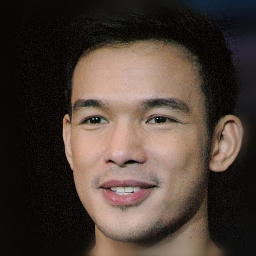

In [ ]:
#@title Align image
image_path = "notebooks/images/input_img.jpg" #@param {type: "string"}
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

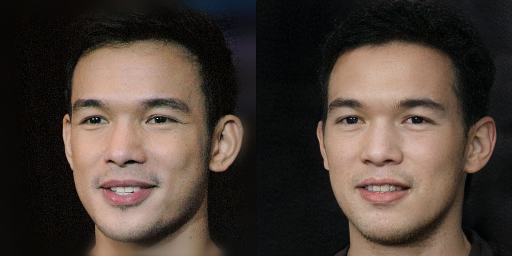

In [ ]:
#@title Invert the image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, 'latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

# 데이터 모은 다음 다시 시작
Relevant only when editing generated image
 

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# 여기까지 했음. 닌자 포함해서 셋업 다시해주기
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'
dataset_name='cars_train'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
! pip install ftfy regex tqdm

os.chdir('/content/gdrive/MyDrive')
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2

%cd
%cd /content/gdrive/MyDrive/StyleCLIP/global_directions
import tensorflow as tf
import numpy as np 
import torch
from clip.clip import load
from PIL import Image
import pickle
import copy
from gdown import download as drive_download
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from global_directions.manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load("ViT-B/32", device=device) 

M=Manipulator(dataset_name) 
fs3=np.load('./npy/cars_train/fs3.npy')
np.set_printoptions(suppress=True)

image_path = None
img_index = None

#Iterate over generated images#



In [ ]:
%cd
%cd /content/gdrive/MyDrive/StyleCLIP/global_directions

for img_index in range(1,2000):

  # Choose generated mode
  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
  M.num_images=len(img_indexs)
  M.alpha=[0]
  M.manipulate_layers=[0]
  codes,out=M.EditOneC(0,dlatent_tmp) 
  original=Image.fromarray(out[0,0]).resize((512,512))
  M.manipulate_layers=None

  # Manipulate with text
  neutral='car'
  target='car from sixties'
  classnames=[target,neutral]
  dt=GetDt(classnames,model)

  # Modify manipulation strength (alhpa) and disentangle threshold (beta)
  # beta=0.1, alpha=1
  beta = 0.21 # min:0.08, max:0.3, step:0.01
  alpha = 5 # min:-10, max:10, step:0.1
  M.alpha=[alpha]
  boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
  codes=M.MSCode(dlatent_tmp,boundary_tmp2)
  out=M.GenerateImg(codes)
  generated=Image.fromarray(out[0,0]).resize((512,512))
  generated.save('/content/gdrive/MyDrive/StyleCLIP/global_directions/data/'+target+'/{0}.jpg'.format(img_index), 'JPEG')

/root
/content/gdrive/MyDrive/StyleCLIP/global_directions
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 21
0.3596
num of channels being manipulated: 

# Choose Mode (and show input image) -> 이거 안 씀
Run for both real and generated image

In [ ]:
img_index =  100#@param {type:"number"}

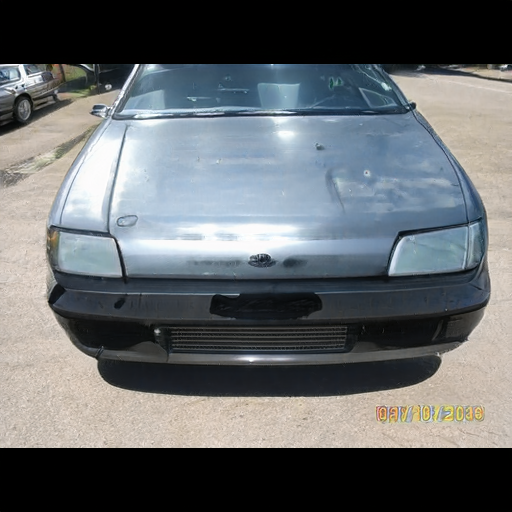

In [ ]:
mode='generated image' #@param ['real image', 'generated image']

if mode == 'real image':
  img_index = 0
  latents=torch.load('/content/encoder4editing/latents.pt')
  w_plus=latents.cpu().detach().numpy()
  dlatents_loaded=M.W2S(w_plus)

  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
elif mode == 'generated image':
  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original


# input text description 
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |


In [ ]:
neutral='car' #@param {type:"string"}
target='car from nineties' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.3518


# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

In [ ]:

#beta=0.1
#alpha=1
beta = 0.21 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 5 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')

num of channels being manipulated: 63


(-0.5, 511.5, 511.5, -0.5)

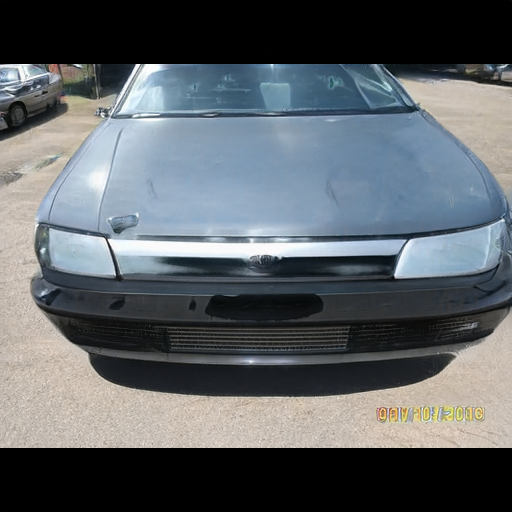

In [ ]:
#@title generate a high-res manipulated photo for download
generated

In [ ]:
# Generate ssh key pairs on your local machine, don't forget to keep the paraphrase empty, check this tutorial.

# Upload it to colab, check the following screenshot

from google.colab import files
uploaded = files.upload()

# Move the ssh kay pairs to /root and connect to git

# remove previously ssh files
! rm -rf /root/.ssh/*
! mkdir /root/.ssh
# uncompress your ssh files
! tar -xvzf ssh.tar.gz
# copy it to root
! cp ssh/* /root/.ssh && rm -rf ssh && rm -rf ssh.tar.gz ! chmod 700 /root/.ssh
# add your git server e.g gitlab as a ssh known host
! ssh-keyscan gitlab.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts
# set your git account
! git config --global user.email "email"
! git config --global user.name "username"
# finally connect to your git server
! ssh git@gitlab.com
# Authenticate your private repository, please check this Per-repository deploy keys.

# Use ! git@gitlab.com:{account}/{projectName}.git
# note: to use push, you have to give write access for the public ssh key that you authenticate git server with.